In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from tqdm import tqdm_notebook as tqdm
import scipy as sp
import scipy.stats as sps
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import gc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import typing as tp
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
import matplotlib.patches as mpatches
from AnomalyGenerator import Anomaly, AnomalyGenerator
from nab_scorer import NAB
from RobustRandomCutForest import RobustRandomCutForest
from SimpleLSTMmodel import SimpleLSTMAnomalyModel
from KNNmodel import KNNmodel
from FourierModel import FourierAnomalyModel
from KNNmodel import KNNmodel
from eSNNAnomalyClassifierModified import eSNNAnomalyClassifierModified
from eSNNAnomalyClassifier import eSNNAnomalyClassifier
from AnomalyModelRunner import run_model_on_generator, show_model_results
sns.set()
%matplotlib inline
import os

In [2]:
def add_anomalies_from_array_into_nab_generator(anomaly_indexes, anomaly_type, generator, size):
    for curr_ind in anomaly_indexes:
        generator.add_real_data_anomaly(start_index=curr_ind,
                                anomaly_type=anomaly_type,
                                size=size)
    return generator

In [5]:
import glob
import json
def get_nab_generators():
    root_path = '/Users/lunin-dv/Desktop/Diploma/NAB/NAB/data/'
    ans_path = '/Users/lunin-dv/Desktop/Diploma/NAB/NAB/labels/raw/'
    tables = []
    for filename in glob.iglob(root_path + '**/*.csv', recursive=True):
         tables.append(filename.split(root_path)[1])
    
    labels = {}
    for filename in glob.iglob(ans_path + '**/*.json', recursive=True):
        with open(filename) as json_file:
            data = json.load(json_file)
        labels.update(data)

    for key in labels:
        time_ans = []
        for val in labels[key]:
            time_ans.append(pd.to_datetime(val))
        labels[key] = time_ans
        
    generators = []
    for curr_table in tables:
        path = root_path + curr_table
        df = pd.read_csv(path)
        generator = AnomalyGenerator().read_data_from_pd_dataframe(df,
                                                   time_column="timestamp")
        size = int(0.1 * len(df) / (len(labels[curr_table]) + 1e-5))
        generator.reset()
        anomaly_type = {'value': Anomaly.individual}
        anomaly_indexes = \
        df[pd.to_datetime(df['timestamp']).isin(labels[curr_table])].index - size // 2
        generator = add_anomalies_from_array_into_nab_generator(anomaly_indexes, 
                                                anomaly_type, generator, size)
        generators.append(generator)
    return generators

In [6]:
nab_generators  = get_nab_generators()

In [7]:
from itertools import chain
import gc
from IPython.display import clear_output

In [8]:
generators = nab_generators

In [9]:
def create_corrected_indexes_with_thr(pvalue_array, alpha):
    corrected_indexes = []
    for ind in range(len(pvalue_array)):
        corrected_indexes.append(np.where(pvalue_array[ind] > alpha)[0])
    return corrected_indexes

In [10]:
scorer_1 = NAB(a_fp = -1)
scorer_01 = NAB(a_fp = -0.1)
scorer_005 = NAB(a_fp = -0.05)
scorer_001 = NAB(a_fp = -0.01)
anomalies  = [gen.anomalies for gen in generators]

In [14]:
window_size = 100
min_pval = 1 - 1e-10
model_all_pvalues = []
for gen in tqdm(generators):
    model_pvals, _ = \
                run_model_on_generator(eSNNAnomalyClassifier, gen, 
                                       shape=1, ni_size=10, no_max_size=50,
                                       window_size=window_size, ts=1000, sim=0.15, mod=0.6, C=0.1, 
                                       value_correction_constant=0.9,
                                       beta = 1.6, min_pvalue=min_pval,
                                       verbose=False)
    gc.collect()
    model_all_pvalues.append(model_pvals)
model_indexes = create_corrected_indexes_with_thr(model_all_pvalues, min_pval)
print("FINAL")
scorer_001.score(anomalies, model_indexes), scorer_005.score(anomalies, model_indexes),\
scorer_01.score(anomalies, model_indexes), scorer_1.score(anomalies, model_indexes)

/Users/lunin-dv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.




FINAL


(1.5848826247228165,
 -331.5713851957132,
 -748.0167199712583,
 -8244.032745931192)

In [11]:
gc.collect()
window_size = 100
min_pval = 0.9999
model_all_pvalues = []
for gen in tqdm(generators):
    model_pvals, _ = \
                run_model_on_generator(eSNNAnomalyClassifierModified, 
                                       gen, shape=5, ni_size=10, no_max_size=200,
                                       window_size=window_size, ts=1000, sim=0.1, mod=0.6, C=0.1, 
                                       value_correction_constant=0.9,
                                       beta = 1.6, min_pvalue=min_pval,
                                       errror_type='dynamically',
                                       verbose=False)
    gc.collect()
    model_all_pvalues.append(model_pvals)
model_indexes = create_corrected_indexes_with_thr(model_all_pvalues, min_pval)
print("FINAL")
scorer_001.score(anomalies, model_indexes), scorer_005.score(anomalies, model_indexes),\
scorer_01.score(anomalies, model_indexes), scorer_1.score(anomalies, model_indexes)

/Users/lunin-dv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """




FINAL


/Users/lunin-dv/Desktop/Diploma/github/Anomaly/nab_scorer.py:33: RuntimeWarning: overflow encountered in exp
  return const * (2 / (1 + np.exp(self.function_const * y)) - 1)


(60.147115447486264,
 -25.314842930635997,
 -132.1422909032889,
 -2055.036354411035)

In [15]:
gc.collect()
window_size = 100
min_pval = 0.9999
model_all_pvalues = []
for gen in tqdm(generators):
    model_pvals, _ = \
                run_model_on_generator(eSNNAnomalyClassifierModified, 
                                       gen, shape=5, ni_size=10, no_max_size=200,
                                       window_size=window_size, ts=1000, sim=0.17, mod=0.6, C=0.1, 
                                       value_correction_constant=0.9,
                                       beta = 1.6, min_pvalue=min_pval,
                                       errror_type='min',
                                       verbose=False)
    gc.collect()
    model_all_pvalues.append(model_pvals)
model_indexes = create_corrected_indexes_with_thr(model_all_pvalues, min_pval)
print("FINAL")
scorer_001.score(anomalies, model_indexes), scorer_005.score(anomalies, model_indexes),\
scorer_01.score(anomalies, model_indexes), scorer_1.score(anomalies, model_indexes)

/Users/lunin-dv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """




FINAL


(51.94123309454519,
 -39.45349839282061,
 -153.69691275202788,
 -2210.0783712177576)

In [17]:
window_size = 100
min_pval = 0.9999
model_all_pvalues = []
for gen in tqdm(generators):
    model_pvals, _ = \
                run_model_on_generator(eSNNAnomalyClassifierModified, 
                                       gen, shape=5, ni_size=10, no_max_size=200,
                                       window_size=window_size, ts=1000, sim=0.17, mod=0.6, C=0.1, 
                                       value_correction_constant=0.9,
                                       beta = 1.6, min_pvalue=min_pval,
                                       errror_type='max',
                                       verbose=False)
    gc.collect()
    model_all_pvalues.append(model_pvals)
model_indexes = create_corrected_indexes_with_thr(model_all_pvalues, min_pval)
print("FINAL")
scorer_001.score(anomalies, model_indexes), scorer_005.score(anomalies, model_indexes),\
scorer_01.score(anomalies, model_indexes), scorer_1.score(anomalies, model_indexes)

/Users/lunin-dv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.




FINAL


(50.616394374586676,
 -99.83670761975905,
 -287.90308511269063,
 -3673.0978799854643)

In [18]:
window_size = 100
min_pval = 0.9999
model_all_pvalues = []
for gen in tqdm(generators):
    model_pvals, _ = \
                run_model_on_generator(eSNNAnomalyClassifierModified, 
                                       gen, shape=5, ni_size=10, no_max_size=200,
                                       window_size=window_size, ts=1000, sim=0.17, mod=0.6, C=0.1, 
                                       value_correction_constant=0.9,
                                       beta = 1.6, min_pvalue=min_pval,
                                       errror_type='mean',
                                       verbose=False)
    gc.collect()
    model_all_pvalues.append(model_pvals)
model_indexes = create_corrected_indexes_with_thr(model_all_pvalues, min_pval)
print("FINAL")
scorer_001.score(anomalies, model_indexes), scorer_005.score(anomalies, model_indexes),\
scorer_01.score(anomalies, model_indexes), scorer_1.score(anomalies, model_indexes)

/Users/lunin-dv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.




FINAL


(59.51123948366657,
 -55.36248207435943,
 -198.95463402189165,
 -2783.6133690774686)

In [19]:
model_all_pvalues = []
for gen in tqdm(generators):
    model_pvals, _ = \
                run_model_on_generator(eSNNAnomalyClassifierModified, 
                                       gen, shape=5, ni_size=10, no_max_size=200,
                                       window_size=window_size, ts=1000, sim=0.17, mod=0.6, C=0.1, 
                                       value_correction_constant=0.9,
                                       beta = 1.6, min_pvalue=min_pval,
                                       errror_type='dynamically',
                                       distribution=sps.laplace(loc=0, scale=1),
                                       verbose=False)
    gc.collect()
    model_all_pvalues.append(model_pvals)
model_indexes = create_corrected_indexes_with_thr(model_all_pvalues, min_pval)
print("FINAL")
scorer_001.score(anomalies, model_indexes), scorer_005.score(anomalies, model_indexes),\
scorer_01.score(anomalies, model_indexes), scorer_1.score(anomalies, model_indexes)

/Users/lunin-dv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/Users/lunin-dv/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:4059: RuntimeWarning: overflow encountered in exp
  return np.where(x > 0, 1.0-0.5*np.exp(-x), 0.5*np.exp(x))




FINAL


(48.69747899159665, 38.44537815126051, 25.630252100840337, -205.0420168067227)

In [42]:
knn_all_pvalues = []
for gen in tqdm(generators):
    knn_pvals, _ = \
                run_model_on_generator(KNNmodel, gen, 
                                       dimension = 1, training_size=100, 
                                       calibration_size = 100,
                                       vector_size=3,
                                       neigbouhrs=10)
    knn_all_pvalues.append(knn_pvals)
knn_indexes = create_corrected_indexes_with_thr(knn_all_pvalues, 0.9965)
print("FINAL")
scorer_001.score(anomalies, knn_indexes), scorer_005.score(anomalies, knn_indexes),\
scorer_01.score(anomalies, knn_indexes), scorer_1.score(anomalies, knn_indexes)

/Users/lunin-dv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  




FINAL


/Users/lunin-dv/Desktop/Diploma/github/Anomaly/nab_scorer.py:33: RuntimeWarning: overflow encountered in exp
  return const * (2 / (1 + np.exp(self.function_const * y)) - 1)


(56.852997803015704,
 -102.28963283366076,
 -301.2179211295065,
 -3881.927110454752)

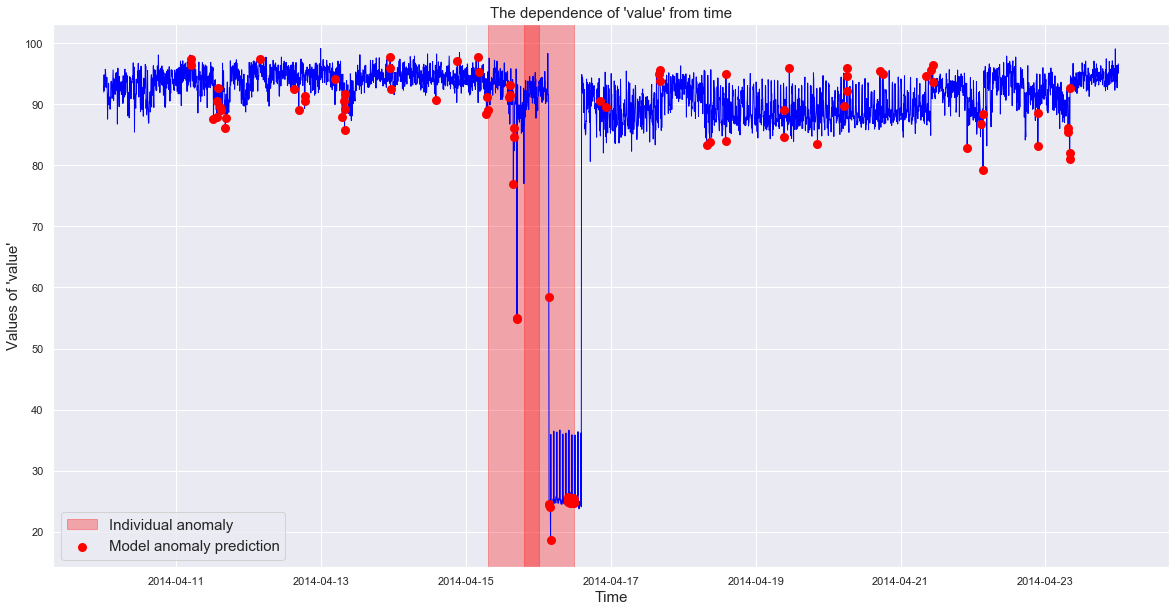

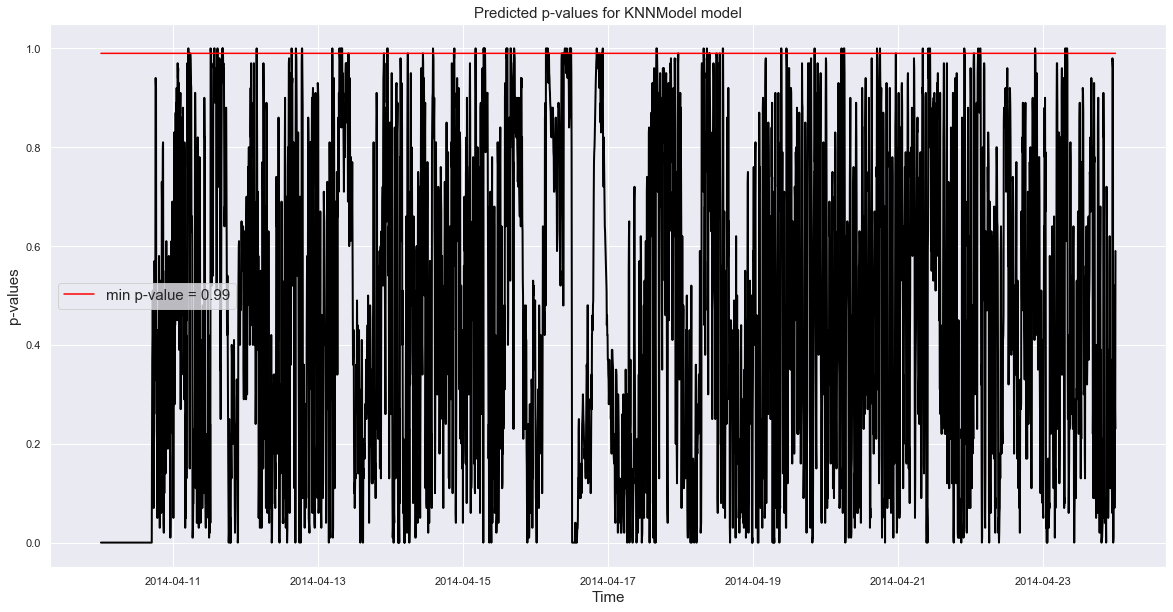

In [48]:
show_model_results('value', "KNNModel", 
                   generators[0], knn_all_pvalues[0], alpha=0.99)

In [13]:
fft_all_pvalues = []
for gen in tqdm(generators):
    fft_pvals, _ = \
                run_model_on_generator(FourierAnomalyModel, 
                                       gen,
                                       dimension=1, train_window_size=200,
                                       predict_window_size=2,
                                       last_scores_size=8000,
                                       small_window_size=10)
    fft_all_pvalues.append(fft_pvals)

fft_indexes = create_corrected_indexes_with_thr(fft_all_pvalues, 0.98)
print("FINAL")
scorer_001.score(anomalies, fft_indexes), scorer_005.score(anomalies, fft_indexes),\
scorer_01.score(anomalies, fft_indexes), scorer_1.score(anomalies, fft_indexes)

/Users/lunin-dv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  




FINAL


(51.680786287539995,
 -10.503631587510332,
 -88.23415393132328,
 -1487.3835561199533)

In [21]:
forest_all_pvalues = []
for gen in tqdm(generators):
    forest_pvals, forest_anomaly_indexes = \
            run_model_on_generator(RobustRandomCutForest, 
                                   gen,
                                   train_size=10,
                                   queue_size=200)
    forest_all_pvalues.append(forest_pvals)
    
forest_indexes = create_corrected_indexes_with_thr(forest_all_pvalues, 0.98)
print("FINAL")
scorer_001.score(anomalies, forest_indexes), scorer_005.score(anomalies, forest_indexes),\
scorer_01.score(anomalies, forest_indexes), scorer_1.score(anomalies, forest_indexes)

/Users/lunin-dv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/Users/lunin-dv/Desktop/Diploma/github/Anomaly/RobustRandomCutForest.py:67: RuntimeWarning: invalid value encountered in double_scalars
  pvalue = 2 * sps.norm(0, 1).cdf(abs(small_mu - big_mu) / sigma) - 1


/Users/lunin-dv/Desktop/Diploma/github/Anomaly/AnomalyModelRunner.py:23: RuntimeWarning: invalid value encountered in greater
  return pvals, np.where(pvals > alpha)[0]




FINAL


/Users/lunin-dv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


(47.151260504201694,
 10.54621848739492,
 -35.210084033613505,
 -858.8235294117648)

In [22]:
lstm_all_pvalues = []
for gen in tqdm(generators):
    lstm_pvals, _ = \
            run_model_on_generator(SimpleLSTMAnomalyModel, 
                                   gen,
                                   in_out_size=1,
                                   small_window_size=5,
                                   train_size=10)
    lstm_all_pvalues.append(lstm_pvals)
print("FINAL")
lstm_indexes = create_corrected_indexes_with_thr(lstm_all_pvalues, 0.99)
scorer_001.score(anomalies, lstm_indexes), scorer_005.score(anomalies, lstm_indexes),\
scorer_01.score(anomalies, lstm_indexes), scorer_1.score(anomalies, lstm_indexes)

/Users/lunin-dv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/Users/lunin-dv/Desktop/Diploma/github/Anomaly/SimpleLSTMmodel.py:137: RuntimeWarning: invalid value encountered in double_scalars
  pvalue = 2 * sps.norm(0, 1).cdf(abs(small_mu - big_mu) / sigma) - 1




FINAL


/Users/lunin-dv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


(39.5924936013349,
 -33.970305102569505,
 -125.92380348244997,
 -1781.0867743202978)